# FINAL CLEANING AND DATA QUALITY CHECKS

Along this script we are going to undertake the following tasks:

1. Duplicates analysis
2. Nulls
3. Dates analysis: (outliers,etc)
4. Orders analysis (outliers,etc)

# Importing libraries and storing the dataframe in memory

In [ ]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = None

In [ ]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../../data/02_intermediate/"
original_file_path = file_path + "b2.txt"

# Column names
col_names = ["product_id",
          "description",
          "order_date",
          "section",
          "BmUP",
          "VeUp",
          "CzUP",
          "AaUP",
          "SeUP",
          "JPUP",
          "RzUP",
          "AeUP",
          "LiUP",
          "EnUP",
          "GoUP",
          "GrUP",
          "AnUP",
          "MoUP",
          "PoUP",
          "MsUP",
          "ViUP",
          "ZiUO",
          "GeUP"]
filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [ ]:
target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 


In [ ]:
df_transactions_filtered = pd.read_csv(target_products_file_name, sep = sep)

In [ ]:
df_transactions_filtered.head()

In [ ]:
df_transactions_filtered.shape

In [ ]:
df_transactions_filtered.info()

"order_date" should be date-type but is not, and "units_ordered" should be numeric, but they are not, and there are some nulls... Lets treat the nulls before parsing to the right types. 

Before continuing, lets parse the dataframe to the right column types:

# Parsing column types

### Parsing column "order_date"

In [ ]:
# Parsing "order_date" to date type 
df_transactions_filtered["order_date"] = pd.to_datetime(df_transactions_filtered["order_date"])

In [ ]:
df_transactions_filtered.head(2)

Before cleaning column "units_ordered" we need to clean the null values. Then we will be able to parse it to the right numeric type, which is int.

## NULLs Analysis


In [ ]:
df_transactions_filtered.isnull().sum()

As we saw before, there are only nulls in "units_ordered". The good news is that it does seem to be many of them, lets have a look at it before we decide what to do to them:

After some debate, messy EDA, and careful consideration we decided to eliminate the lines for the following reasons:

1) It is possible that these lines constitute "duplicates" (duplicated in all but their values) for lines that hold a value. If this is the case, these lines would be treated as duplicates in the next step of the quality checks (in which we will see that dropping duplicates is the right move).

2) In case that these lines are not duplicated in the rest of the dataset, removing them will make no difference because we currently don't have the real value of number of units placed in the order, so, when the time comes and we will check for missing value in the series, we will appropriately deal with the matter.

In [ ]:
# Proving point 1: lines with nulls may be due to duplicates 
df_original = pd.read_csv(original_file_path, sep = sep, encoding = "ISO-8859-1",names = col_names )
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

As mentioned above, the smartest option is to eliminate lines with NaN in the unit ordered: 

In [ ]:
df_transactions_filtered_nan_removed = df_transactions_filtered.dropna()

In [ ]:
# Check
df_transactions_filtered.shape[0] - 314 == df_transactions_filtered_nan_removed.shape[0]


### Parsing column "units_ordered" to int

In [ ]:
df_transactions_filtered_nan_removed["units_ordered"]  = df_transactions_filtered_nan_removed["units_ordered"].str.split(",").apply(lambda l: int(l[0]))

In [ ]:
df_transactions_filtered_nan_removed.head()

In [ ]:
df_transactions_filtered_nan_removed.info()

Voila! the types look as they should be looking, and the nulls have been treated. 

# Duplicates Analysis

Lets see if we have any duplicates:

In [ ]:
df_transactions_filtered_nan_removed.duplicated().sum() 

Wow! this was unexpected 120.340 duplicates seems as a big number (it is roughly 1/8 of the rows of the Dataset). 

We need to take a closer look to these duplicates:

In [ ]:
duplicates = df_transactions_filtered_nan_removed[df_transactions_filtered_nan_removed.duplicated()]
duplicates.head()

Interesting, it seems that all have 0 units ordered, but lets dig more into this:

In [ ]:
duplicates["units_ordered"].value_counts()

Unfortunately, it seems that not all the duplicates are 0, otherwise we could have deleted the duplicates. However we now need to find out a bit more the ones greater than 0. 

Lets explore the original file to see what could have happened:

Lets take for example the duplicate with "units_ordered" = 70:

In [ ]:
duplicates[duplicates["units_ordered"]==70]

Lets now search for this specific row in the original dataset that the client gave us:

In [ ]:
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

We consider the theory that many from our duplicates might come from duplicates from the original file.

Lets check it:

In [ ]:
df_original.duplicated().sum()

There many duplicates in the original file, but not enough.

As we melted this file to obtain our own (and to have the information as transactions), this number of duplicates has to be multiplied by the number of stores (10), but even then it falls a little shy of the number of duplicates in our results.

Also, when we have into consideration that most of the duplicates should correspond to products that are not in our filtered dataset, we cannot consider duplicates from the original file as the only (or even, the main) source of duplicates in our file.

Diggind deeper in the matter, we are now going to check a couple of values from our duplicates, in the original dataframe provided to us:

In [ ]:
df_original[(df_original["order_date"]=="20/2/2016 0:00:00")&(df_original["description"].str.contains("TORTELES"))]

We can see that the bottom line is empty except for the store "VeUp" that has the value repeated. Coincidence or patter? lets dig a bit more:

In [ ]:
# Lets take a random one from 
duplicates[duplicates["units_ordered"]==4].sample()

In [ ]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))][["product_id","description","order_date","section","RzUP"]]

This case beneath is very interesting:
    
We can see that for a given produt id, with the same description and on the same order date, there are several orders:

* Some of these orders are duplicates

* Some lines correspond to one order from one specific store, but we have two different orders asking for diffent quantities of the product

In [ ]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))]

Ok..., at this point the information was too confusing: One store, in one day has multiple orders; all very similar.. And when that store is compared to the other stores for the same day, its even more confusing... So we decided to meet with the client and ask for clarifications:

These are the conclusions from the meeting:

 - In the original file, there should only be one line per day, if there are more it could mean two things:
     - if the additional line is all 0 except for one store, AND that store has 0 in the main line, it means that they had to manually input their order in the system.
     - if one store has duplicated orders for a given day-product, it means they made a mistake. 
 - Also, if a store orders different quantities of the same product in the same day, its probably an error and they only take the largest order.
 
 The main conclusion from the client is that we can group by Date - product - store and take the largest order to remove duplicates... HOWEVER, before doing this, we need to take into account another situation: One product could have been ordered by a store, in a given day using several different product id / descriptions. If we group by, we may be loosing orders, unless we are very restrictive. 

In [ ]:
#Lets take the max value for each line:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id', 'description','order_date', 'section', 'store', 'desc_normalized', 'target_names_prod_by_prod']).max().reset_index()

In [ ]:
df_non_duplicated_lines.duplicated().sum()

Perfect, we don't have duplicates!... Or yes...

Actually, we may still have duplicates, one store could have created duplicates that we have not identified by ordering the same product by two different ID's or using different descriptions.

- If they were using different ID's this could would mainly mean that they intentionally want two different orders (perhaps custom orders, and normal order)

- If they were using different product descriptions, it would probably mean that they introduced the order two times, however lets explore this situation a bit more:


In [ ]:
# Lets count the number of times a duplicated line differs only by the raw desciption, and has a value greater than 0:
aux=df_non_duplicated_lines.drop('description', axis=1)
aux2 = aux[aux.duplicated()]
aux2[aux2["units_ordered"]>0]["units_ordered"].shape

In [ ]:
aux2["units_ordered"].max()

As seen, there are not a lot of values involved, neither have big weights.

Under the consideration that the total aggregated error is 16 units in a series spanning a decade and with millions of units ordered, we consider it safe to simply eliminate this transactions.

In [ ]:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id','order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].max().reset_index()

In [ ]:
df_non_duplicated_lines.head()

In [ ]:
df_non_duplicated_lines.duplicated().sum()

We are going to check the resulting shape of our dataframe, to do a brief sanity check by seeing how many lines have been deleted:

In [ ]:
df_non_duplicated_lines.shape

# Data quality:


## 1. File Shape (one line per day-store-product)

The dataset should contain only one line per product, date, and store. However, we already know that one product could have been ordered by given store, in a given day with several products ID's. 

The expectation is that there could be several different orders for the same product, same day and same store, because, as we saw when filtering our products, there were several product IDs for most of them that checked all the boxes of the description, as we can see in the image below (corresponding to the "mousse 3 chocolates"):

<img src=./IM00.png>

lets check it:

In [ ]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].count()

In [ ]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].max()

For this orders we are not going to pick the biggest, as before, but sum their quantities: indeed, they have different product ids, but they correspond to the very same product, so adding up the quantities is what will give us the total ammount a particular store orders in a particular day:


In [ ]:
df_to_check = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].sum().reset_index()
df_to_check.head(20)

## 2. Checking for outliers:

We are now going to check for outliers in our data.

We are going to undertake this take little by little:

In [ ]:
df_to_check['units_ordered'].mean()

In [ ]:
df_to_check['units_ordered'].max()

In [ ]:
df_to_check.sort_values('units_ordered', ascending=False).head(20)

In [ ]:
df_to_check['units_ordered'].plot(figsize=(18,4))

Same plot eliminating the largest values up to a threshold:

In [ ]:
n=800

df_to_check[df_to_check['units_ordered']<n]['units_ordered'].plot(figsize=(18,4))

As we can see, now our values present a more coherent shape.

Now, plotting a histogram of our values to see

In [ ]:
histo1=plt.hist(df_to_check['units_ordered'], bins=82)

In [ ]:
histo1

Seeing that most of the weight is between 0 and 100, we plot the same, but for values higher than 100:

In [ ]:
histo2=plt.hist(df_to_check[df_to_check['units_ordered']>100]['units_ordered'], bins=80)

In [ ]:
histo2

In [ ]:
histo2[0].sum()

And, finally, let's take a look on this extreme data:

In [ ]:
df_to_check[df_to_check['store']=='EnUP'].sort_values('units_ordered', ascending=False).head(10)

And compare it with the average values for an specific product:

In [ ]:
aux3=df_to_check.groupby(['store', 'target_names_prod_by_prod']).mean().reset_index()

aux3[aux3['store']=='EnUP']

It can be seen that the peaks numbers for this particular store are between 25 and 200 times their mean order.

**First preliminary conclussions:**

We can see that, in our whole data, only 239 values are greater than 100, and even being such the case, most of them (191 from the 239 values) have values not superior to 200, what leaves us with only 28 values greater than 200.

Even though, this data could be anomalies in the time series explained by events.

Football matches, national or local holidays, or large custom orders, such as weddings, could be the reason for this strange data.

But, as the focus of our project is not at large custom orders (indeed, the client handles them ad hoc, and what it has asked us to do is to provide a solution for the day-to-day orders), there is very little interest for us in such kind of anomalies.

However, we are interested in trying to keep the effects of everyday events such as football matches, holidays or the weather, in the daily orders from the stores to the factory.

So, perhaps keeping an intermediate threshold would do the trick, because:

* the very large values are just a few and can be only due to a mistake in the order or due to large custom orders from specific clients for special events,


* keeping at the same time some of the high values (high, but not extravagantly high), that are not produced by the effects above, but to the ones that we are interested in trying to encompass and explain with our model.

**But:**

Before proceeding to do so, there is still an interesting question pending: is this phenomenom appearing because of operations with the data, or does it come from the original dataset?

We are going to check the highest values in our original dataset now:

In [ ]:
df_original2=df_original.dropna()

stores=list(df_original2.columns[4:])

results_dict=dict()
total_list=list()

for element in stores:
    
    values=df_original2[element]
    
    values2=values.str.split(",").apply(lambda l: int(l[0]))
    
    total_list.append(list(values2))
    
    results_dict[element]=values2

print(values2.sort_values(ascending=False)[:20])

320290     1210
44061       400
224278      300
45286       300
1409477     300
1409476     300
535338      300
97221       300
224277      300
311534      300
43399       300
332583      300
1250620     260
1527766     250
349473      250
1155420     240
174859      200
1363332     200
332584      200
639933      200
Name: GeUP, dtype: int64


For starters, we take the series of values for the last store and take a look on it:

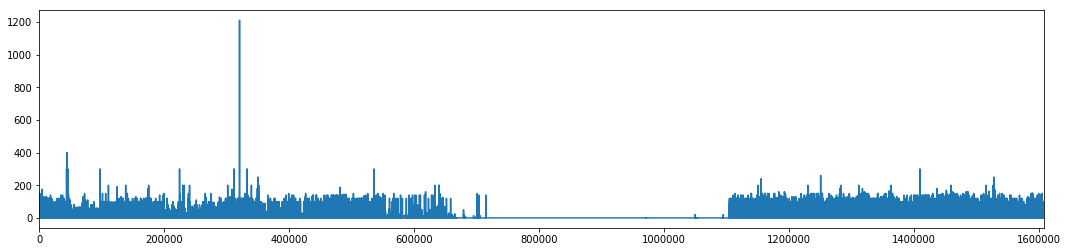

In [ ]:
values2.plot(figsize=(18,4))

We can see that there is just one value that is disproportionatelly large when compared to the rest, and that by removing this extreme value the series presents a much better appearance:

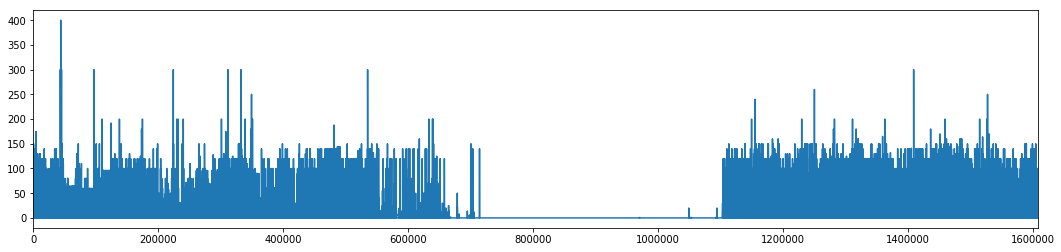

In [ ]:
to_drop=values2[values2==values2.max()].index

values2.drop(to_drop, inplace=True)
values2.plot(figsize=(18,4))

We now want to examine the results for another different store:

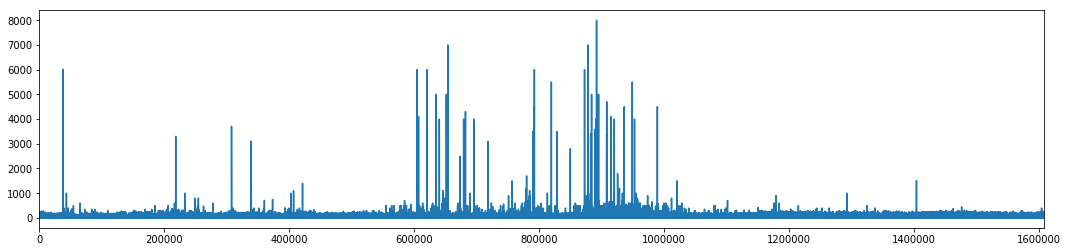

In [ ]:
results_dict['EnUP'].plot(figsize=(18,4))

In [ ]:
plt.figure(figsize=(18,4))
plt.plot(total_list)

In [ ]:
df_to_check

In [90]:
aaa = pd.pivot_table(data=df_for_work, index=['store', 'target_names_prod_by_prod'],)

In [91]:
aaa

section  units_ordered
store target_names_prod_by_prod                            
AaUP  baguette                             0      11.477378
      croissant petit                      0       7.508097
      croissant simple                     0      16.894885
      milhojas frambuesa                   0       2.114654
      mousse tres chocolates               0       0.153201
...                                      ...            ...
ZiUO  palmera chocolate                    0       1.660639
      postre de fresas y mascarpone        0       4.679483
      tarta de manzana                     0       0.000235
      tarta opera                          0       0.000000
      tortel                               0       0.000000

[190 rows x 2 columns]